In this notebook, we consider a ZDT1 problem with Gaussian noise, and benckmark two "denoising" methods:
* a naive average method,
* the KNN-Avg algorithm.

In [1]:
import nmoo

The first step is to construct our problem pipelines. We start with a `ZDT1` instance, that we wrap in a `ProblemWrapper`. In nmoo, `ProblemWrapper` is the base class to modify problems, in our case adding and removing noise. Additionally, `ProblemWrapper` and classes deriving from it maintain a history of every call made to their `_evaluate` method (see the [pymoo documentation](https://pymoo.org/getting_started.html#By-Class)).

Next, we add a Gaussian noise of type `N(0, 0.25)` and the averaging algorithm.

In [2]:
from pymoo.problems.multi import ZDT1

zdt1 = ZDT1()
wrapped_zdt1_1 = nmoo.WrappedProblem(zdt1)
noisy_zdt1_1 = nmoo.noises.GaussianNoise(
    wrapped_zdt1_1, 
    {"F": (0.0, 0.25)},
)
avg_zdt1 = nmoo.denoisers.ResampleAverage(noisy_zdt1_1, n_evaluations=10)

We construct a similar pipeline for the KNN-Avg algorithm. Note that although we can reuse the same pymoo `Problem` instance (in this case, `zdt1`), it is advised to create a new wrapped problem and a new noisy problem, since nmoo `ProblemWrapper` is stateful.

In [3]:

wrapped_zdt1_2 = nmoo.WrappedProblem(zdt1)
noisy_zdt1_2 = nmoo.noises.GaussianNoise(
    wrapped_zdt1_2, 
    {"F": (0.0, 0.25)},
)
knnavg_zdt1 = nmoo.denoisers.KNNAvg(
    noisy_zdt1_2,
    distance_weight_type="squared",
    max_distance=1.0,
    n_neighbors=100,
)

Now, we setup an algorithm that will try and solve our `avg_zdt1` and `knnavg_zdt1` problems.

In [4]:
from pymoo.algorithms.nsga2 import NSGA2

nsga2 = NSGA2(
    pop_size=40,
    n_offsprings=10,
    eliminate_duplicates=True,
)

Finally, we setup our benchmark. It will run NSGA2 against `avg_zdt1` and `knnavg_zdt1` five times each. Additionally, we specify a Pareto front population to measure the performance, not of NSGA2, but of KNN-Avg against the averaging method.

In [5]:
import os

from pymoo.factory import get_termination

OUT_PATH = "./out"
if not os.path.isdir(OUT_PATH):
    os.mkdir(OUT_PATH)

pareto_front = zdt1.pareto_front(100)

benchmark = nmoo.benchmark.Benchmark(
    output_dir_path=OUT_PATH,
    problems={
        "knnavg": {
            "problem": knnavg_zdt1,
            "pareto_front": pareto_front,
        },
        "avg": {
            "problem": avg_zdt1,
            "pareto_front": pareto_front,
        },
    },
    algorithms={
        "nsga2": {
            "algorithm": nsga2,
        },
        "nsga2_10": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 10),
        },
        "nsga2_100": {
            "algorithm": nsga2,
            "termination": get_termination("n_gen", 100),
        },
    },
    n_runs=5,
)

In [6]:
%%time
benchmark.run(verbose=50)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Results of the benchmark are automatically saved:

In [7]:
! ls -l ./out

total 52048
-rw-r--r--  1 cedric  staff   712580 Jun  7 12:05 avg.nsga2.1.1.npz
-rw-r--r--  1 cedric  staff  2426792 Jun  7 12:05 avg.nsga2.1.2.npz
-rw-r--r--  1 cedric  staff  1009080 Jun  7 12:05 avg.nsga2.1.3.npz
-rw-r--r--  1 cedric  staff   435121 Jun  7 12:04 avg.nsga2.2.1.npz
-rw-r--r--  1 cedric  staff  1487280 Jun  7 12:04 avg.nsga2.2.2.npz
-rw-r--r--  1 cedric  staff   612767 Jun  7 12:04 avg.nsga2.2.3.npz
-rw-r--r--  1 cedric  staff   245368 Jun  7 12:04 avg.nsga2.3.1.npz
-rw-r--r--  1 cedric  staff   853844 Jun  7 12:04 avg.nsga2.3.2.npz
-rw-r--r--  1 cedric  staff   345677 Jun  7 12:04 avg.nsga2.3.3.npz
-rw-r--r--  1 cedric  staff   346747 Jun  7 12:04 avg.nsga2.4.1.npz
-rw-r--r--  1 cedric  staff  1173425 Jun  7 12:04 avg.nsga2.4.2.npz
-rw-r--r--  1 cedric  staff   489243 Jun  7 12:04 avg.nsga2.4.3.npz
-rw-r--r--  1 cedric  staff   271373 Jun  7 12:04 avg.nsga2.5.1.npz
-rw-r--r--  1 cedric  staff   918936 Jun  7 12:04 avg.nsga2.5.2.npz
-rw-r--r--  1 cedric  staff   381675

The benchmark results are saved in `benchmark.csv`. They can also be accessed by `benchmark._results`. The rest are problem call histories, named after the following scheme:
```
<problem_name>.<algorithm_name>.<n_run>.<level>.npz
```
For example, `knnavg.nsga2_100.3.2.npz` is the `GaussianNoise` history (level 2) of the 3rd run of `NSGA2` (100 generations) on the `knnavg` pipeline.

Let's now visualize the results. The final result of all runs can be found using the `Benchmark.final_results` method:

In [8]:
benchmark.final_results()

,algorithm,problem,n_run,n_gen,timedelta,perf_gd,perf_gd+,perf_igd,perf_igd+
0,nsga2,avg,1,480,107512,0.777692,0.775809,0.610692,0.607702
1,nsga2,avg,2,295,832523,0.693719,0.691056,0.424716,0.424712
2,nsga2,avg,3,170,207482,1.096835,1.095171,0.851325,0.851021
3,nsga2,avg,4,230,975657,1.125382,1.123760,0.813786,0.813734
4,nsga2,avg,5,180,493096,0.913397,0.911740,0.678981,0.678981
5,nsga2,knnavg,1,320,481317,1.132726,1.108668,0.692688,0.692522
6,nsga2,knnavg,2,300,822842,0.999688,0.979837,0.560397,0.560011
7,nsga2,knnavg,3,266,249453,0.714377,0.661080,0.140829,0.124476
8,nsga2,knnavg,4,328,974310,0.884845,0.847930,0.428373,0.421609
9,nsga2,knnavg,5,225,602573,0.746559,0.716316,0.333618,0.326541


The following boxplot indicates that, with the same number of calls to `ZDT1`, KNN-Avg offers a better GD+ performance. However, on the number of generation is fixed or unconstrained, then the averaging method is better.

<AxesSubplot:xlabel='problem', ylabel='perf_gd+'>

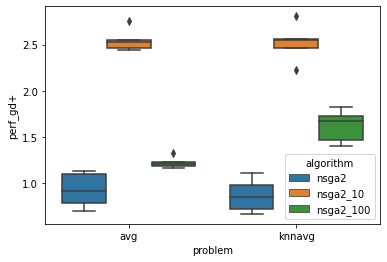

In [9]:
import seaborn as sns

sns.boxplot(
    x="problem", 
    y="perf_gd+", 
    hue="algorithm",
    data=benchmark.final_results(),
)

The following boxplot depicts the runtimes.

<AxesSubplot:xlabel='problem', ylabel='timedelta'>

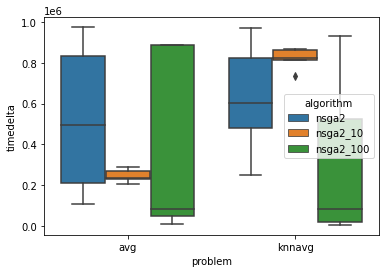

In [10]:
sns.boxplot(
    x="problem", 
    y="timedelta", 
    hue="algorithm",
    data=benchmark.final_results(),
)